In [1]:
import torch 
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg


In [2]:
import scipy.integrate 
solve_ivp = scipy.integrate.solve_ivp 

In [3]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from baseline_models import BaselineMLP
from hnn import HNN 
from utils import L2Loss, rk4

In [4]:
from data import potential_energy, kinetic_energy, total_energy
from data import make_orbits_dataset, coords2state, get_orbit, random_config

In [14]:
DPI = 300
input_dim = 2*4 # two bodies, each with q_x, q_y, p_z, p_y
hidden_dim = 200
learn_rate = 1e-3
input_noise = 0.
batch_size = 200
total_steps =  1500
field_type= 'solenoidal'
print_every =  200
verbose = True
# 'name': '2body'
seed = 0

### Visualizing Examples

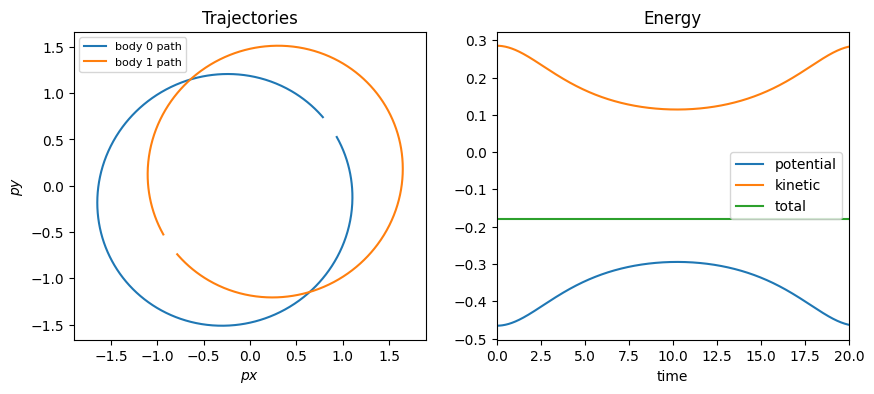

In [15]:
np.random.seed(2)
state = random_config()
orbit, settings = get_orbit(state, t_points=1000, t_span = [0, 20], rtol = 1e-10)

# draw trajectories
fig = plt.figure(figsize=[10,4], dpi=100)
plt.subplot(1,2,1)
plt.title('Trajectories')
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], label='body {} path'.format(i))

plt.axis('equal')
plt.xlabel('$px$') ; plt.ylabel('$py$')
plt.legend(fontsize=8)

plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
plt.plot(settings['t_eval'], potential_energy(orbit), label='potential')
plt.plot(settings['t_eval'], kinetic_energy(orbit), label='kinetic')
plt.plot(settings['t_eval'], total_energy(orbit), label='total')
plt.legend()
plt.xlim(*settings['t_span'])

plt.show()

In [23]:
#Loading the models 
baseline_output_dim = input_dim 
output_dim = 2 
nn_model = BaselineMLP(input_dim, hidden_dim, output_dim)
model = HNN(input_dim, differentiable_model=nn_model, field_type=field_type)
baseline_model = BaselineMLP(input_dim,hidden_dim,baseline_output_dim)


In [24]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
base_optim = torch.optim.Adam(baseline_model.parameters(), lr=1e-3, weight_decay=1e-4)

In [25]:
data = make_orbits_dataset(seed=0)

x_train = torch.tensor(data['train_coords'], requires_grad=True, dtype=torch.float32)  # z = [q p]
x_test = torch.tensor(data['test_coords'], requires_grad=True, dtype=torch.float32)

dxdt_train = torch.tensor(data['train_dcoords'], dtype=torch.float32)  # dz/dt = [dq/dt dp/dt]
dxdt_test = torch.tensor(data['test_dcoords'], dtype=torch.float32)

C:\Users\Neel\AppData\Roaming\Python\Python312\site-packages\scipy\integrate\_ivp\ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `seed`, `rotl`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


In [26]:
print(data.keys())


dict_keys(['train_coords', 'test_coords', 'train_dcoords', 'test_dcoords', 'train_energy', 'test_energy', 'meta'])


### Model Training and Testing

In [27]:
#normal training loop
epochs = total_steps 
stats = {'training_loss':[], 'testing_loss':[] }
for epoch in range(epochs):

    baseline_model.train()

    dxdt_hat_train = baseline_model(x_train)

    train_loss = L2Loss(dxdt_train, dxdt_hat_train)
    stats['training_loss'].append(train_loss)

    base_optim.zero_grad()

    train_loss.backward()

    base_optim.step()

    #testing 
    baseline_model.eval()
    with torch.inference_mode():
        # print(x_test.shape)
        # print(dxdt_hat_train.shape)
        x_test.requires_grad_(True) #enable gradient tracking for the in graph gradient
        dxdt_hat_test = baseline_model(x_test) 
        test_loss = L2Loss(dxdt_hat_test, dxdt_test)
        stats['testing_loss'].append(test_loss)
    
    if epoch % print_every == 0 :
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}  | Test Loss: {test_loss:.5f} ")

Epoch: 0 | Train Loss: 0.10925  | Test Loss: 0.05373 
Epoch: 200 | Train Loss: 0.00047  | Test Loss: 0.00036 
Epoch: 400 | Train Loss: 0.00043  | Test Loss: 0.00034 
Epoch: 600 | Train Loss: 0.00041  | Test Loss: 0.00033 
Epoch: 800 | Train Loss: 0.00039  | Test Loss: 0.00032 
Epoch: 1000 | Train Loss: 0.00038  | Test Loss: 0.00031 
Epoch: 1200 | Train Loss: 0.00037  | Test Loss: 0.00030 
Epoch: 1400 | Train Loss: 0.00036  | Test Loss: 0.00029 


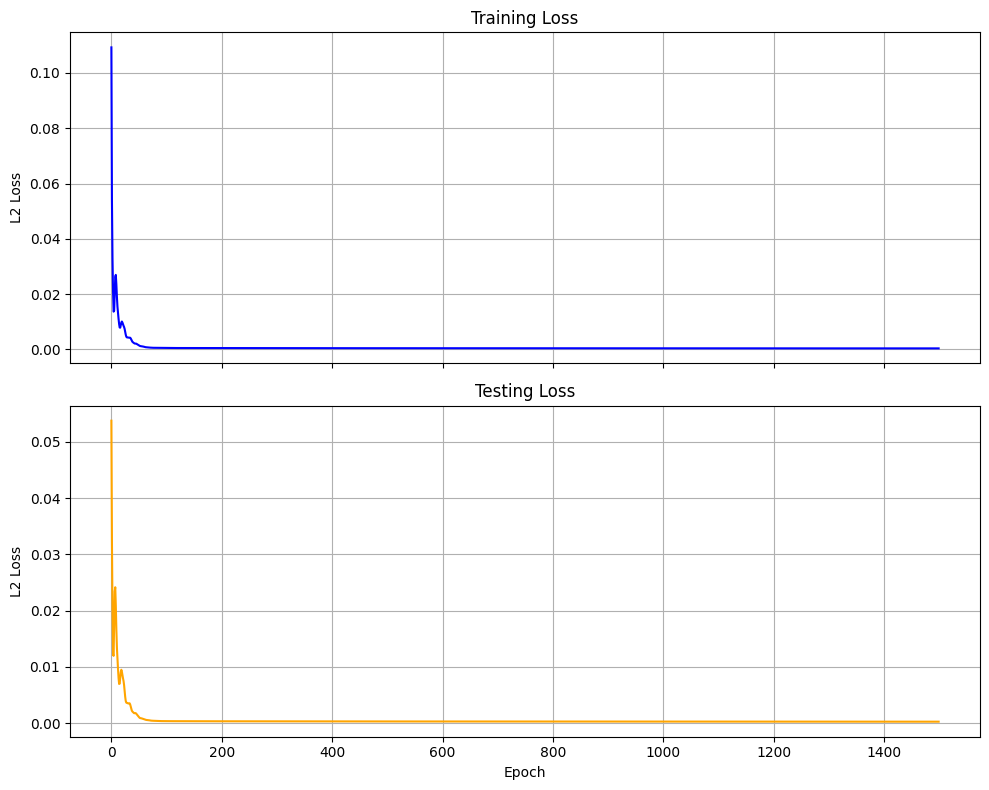

In [28]:
# Convert loss tensors to floats
train_losses = [loss.item() for loss in stats['training_loss']]
test_losses = [loss.item() for loss in stats['testing_loss']]

# Create two subplots: one for training loss, one for testing loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot training loss
axs[0].plot(train_losses, color='blue')
axs[0].set_title('Training Loss')
axs[0].set_ylabel('L2 Loss')
axs[0].grid(True)

# Plot testing loss
axs[1].plot(test_losses, color='orange')
axs[1].set_title('Testing Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('L2 Loss')
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [29]:
#normal training loop
epochs = total_steps 
stats = {'training_loss':[], 'testing_loss':[] }
for epoch in range(epochs):

    model.train()

    dxdt_hat_train = model.time_derivative(x_train)

    train_loss = L2Loss(dxdt_train, dxdt_hat_train)
    stats['training_loss'].append(train_loss)

    optim.zero_grad()

    train_loss.backward()

    optim.step()

    #testing 
   
    x_test.requires_grad_(True) #enable gradient tracking for the in graph gradient
    dxdt_hat_test = model.time_derivative(x_test) 
    test_loss = L2Loss(dxdt_hat_test, dxdt_test)
    stats['testing_loss'].append(test_loss)
    
    if epoch % print_every == 0 :
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}  | Test Loss: {test_loss:.5f} ")
    

Epoch: 0 | Train Loss: 0.05977  | Test Loss: 0.05436 
Epoch: 200 | Train Loss: 0.00086  | Test Loss: 0.00067 
Epoch: 400 | Train Loss: 0.00035  | Test Loss: 0.00027 
Epoch: 600 | Train Loss: 0.00027  | Test Loss: 0.00021 
Epoch: 800 | Train Loss: 0.00023  | Test Loss: 0.00018 


: 

In [ ]:
# Convert loss tensors to floats
train_losses = [loss.item() for loss in stats['training_loss']]
test_losses = [loss.item() for loss in stats['testing_loss']]

# Create two subplots: one for training loss, one for testing loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot training loss
axs[0].plot(train_losses, color='blue')
axs[0].set_title('Training Loss')
axs[0].set_ylabel('L2 Loss')
axs[0].grid(True)

# Plot testing loss
axs[1].plot(test_losses, color='orange')
axs[1].set_title('Testing Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('L2 Loss')
axs[1].grid(True)

plt.tight_layout()
plt.show()